# Big mart sales with full intuition



We will explore the problem in following stages:

Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome

Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.

Data Cleaning – imputing missing values in the data and checking for outliers.

Feature Engineering – modifying existing variables and creating new ones for analysis.

Model Building – making predictive models on the data

First we will load required libraries and the data and check each and every column and understand what effect it can have. 

In [1]:
#importing the required libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# importing the data
train= pd.read_csv("Train_UWu5bXk.csv")
test=  pd.read_csv("Test_u94Q5KV.csv")
# merging train and test together so that all parameters are scaled together 
#created source because we have to separate them afterwards.
train['source']='train'
test['source']='test'
data= pd.concat([train,test],axis=0,ignore_index=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [3]:
print(data.shape,train.shape,test.shape)

(14204, 13) (8523, 13) (5681, 12)


In [4]:
#Now we are checking if any columns have null vale and how much
#here outlet_sales can be ignored as it is for missing in test data
data.isnull().sum()

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

here we have missing values in weight and outlet size, which we will impute in our next steps.


In [5]:
#Determine the average weight per item_identifier:

item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier', aggfunc='mean')
# item_avg_weight.loc['FDP10']

# Mean_values_Item_Type_data=data.groupby('Item_Identifier')['Item_Weight'].mean()
# Mean_values_Item_Type_data

#Taking the missing values
misval= data['Item_Weight'].isnull()
# data.loc[data['Item_Identifier']=='FDP10','Item_Weight']


In [6]:
#Here we will replace missing value with there respective Item_Identifier mean value
# df.loc[rows,columns]

data.loc[misval,'Item_Weight']= data.loc[misval,'Item_Identifier'].apply(lambda x: item_avg_weight.loc[x])
# data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight.loc[x])

data['Item_Weight'].isnull().sum()

0

In [7]:
#Imputing the Outlet_Size missing values
#filling value of Outlet_Size.
#Hypothesis: Outlet_Size depends on Oulet Type and Outlet__Location_Type

twowaytable1=pd.crosstab(data['Outlet_Size'],data['Outlet_Type'])
twowaytable1



Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,,,,
High,0,1553,0,0
Medium,0,1550,1546,1559
Small,880,3100,0,0


In [8]:
twowaytable2=pd.crosstab(data['Outlet_Size'],data['Outlet_Location_Type'])
twowaytable2

Outlet_Location_Type,Tier 1,Tier 2,Tier 3
Outlet_Size,,,
High,0,0,1553
Medium,1550,0,3105
Small,2430,1550,0


In [9]:
# now by both tab we can conclude, grocery store and tier 2 city has small size
# so we will map them.
d={'Grocery Store':'Small', 'Tier 2': 'Small',
  'Supermarket Type2':'Medium', 'Supermarket Type3': 'Medium'}
s= data['Outlet_Type'].map(d)
a= data['Outlet_Location_Type'].map(d)
#map= Used for substituting each value in a Series with another value, that may be derived from a function, 
# a dict or a Series.
data.Outlet_Size=data.Outlet_Size.combine_first(s)
#combine_first: Used for Combine Series values, choosing the calling Series’s values first.
data.Outlet_Size=data.Outlet_Size.combine_first(a)
data['Outlet_Type'].isnull().value_counts()

False    14204
Name: Outlet_Type, dtype: int64

In [10]:
#now we will check the basic properties of numerical value in our data
data.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,14204.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.793380,1997.830681
std,62.086938,1706.499616,0.051459,4.651716,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


Here we judged that item visibility has minimum value of 0, which is strange as if item is present then it should be visible.
and establishment year ranges from 1985 to 2009, but year wont help instead how old it it will help us as majot factor in our prediction.




In [11]:
#replacing 0 visibility with mean visibility
# data['Item_Visibility'].replace(0.0,np.nan)
# data['Item_Visibility'].fillna(data['Item_Visibility'].mean(), inplace=True)
# data['Item_Visibility'].isnull().sum()

In [12]:
#Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier', aggfunc='mean')

#Impute 0 values with mean visibility of that product:
miss_bool = (data['Item_Visibility'] == 0)
print ('Number of 0 values initially: %d'%(sum(miss_bool)))

data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg.loc[x])

(data['Item_Visibility'] == 0).unique()

Number of 0 values initially: 879


array([False])

the Item_Type variable has 16 categories which might prove to be very useful in analysis. So its a good idea to combine them. One way could be to manually assign a new category to each. But there’s a catch here. If you look at the Item_Identifier, i.e. the unique ID of each item, it starts with either FD, DR or NC. If you see the categories, these look like being Food, Drinks and Non-Consumables. So I’ve used the Item_Identifier variable to create a new column:

In [13]:
#Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [14]:
#getting no establishment year
#Years:
data['Outlet_Years'] = 2019 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        21.169319
std          8.371664
min         10.000000
25%         15.000000
50%         20.000000
75%         32.000000
max         34.000000
Name: Outlet_Years, dtype: float64

In [15]:
# now we will check for categorical variables, and how it has difference

data.apply(lambda x: len(x.unique()))

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13688
Item_Weight                    628
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      3
Outlet_Type                      4
source                           2
Item_Type_Combined               3
Outlet_Years                     9
dtype: int64

In [16]:
data.dtypes

Item_Fat_Content              object
Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
Outlet_Location_Type          object
Outlet_Size                   object
Outlet_Type                   object
source                        object
Item_Type_Combined            object
Outlet_Years                   int64
dtype: object

In [17]:
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
categorical_columns

['Item_Fat_Content',
 'Item_Identifier',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Location_Type',
 'Outlet_Size',
 'Outlet_Type',
 'source',
 'Item_Type_Combined']

In [18]:
for i in categorical_columns:
    if i not in ['Item_Identifier','source','Outlet_Identifier']:
        print(i)
        print(data[i].value_counts())
        print(data[i].isnull().value_counts())

Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64
False    14204
Name: Item_Fat_Content, dtype: int64
Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64
False    14204
Name: Item_Type, dtype: int64
Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64
False    14204
Name: Outlet_Location_Type, dtype: int64
Outlet_Size
Small     7996
Medium    4655
High      1553
Name: Outlet_Size, dtype: int

Item_Type: Not all categories have substantial numbers. It looks like combining them can give better results.

In [19]:
#Change categories of low fat:

data['Item_Fat_Content'].value_counts()


data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
data['Item_Fat_Content'].value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

In [20]:
data.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Type_Combined,Outlet_Years
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food,20
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train,Drinks,10
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food,20
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.017834,19.20,1998,OUT010,Tier 3,Small,Grocery Store,train,Food,21
4,Low Fat,NCD19,53.8614,994.7052,Household,0.009780,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train,Non-Consumable,32


Since scikit-learn accepts only numerical variables, I converted all categories of nominal variables into numeric types.

"""Vectorising the data based on categories
Labelencoder will change the different category in column values to respective unique
number ex 0,1,2

Onehotencoder will convert the 0,1,2 category to respective 3 columns with their
binary values or dummy variables

Dummy variable can also be made using pd.get_dummies()
"""

In [21]:
data.columns


Index(['Item_Fat_Content', 'Item_Identifier', 'Item_MRP', 'Item_Outlet_Sales',
       'Item_Type', 'Item_Visibility', 'Item_Weight',
       'Outlet_Establishment_Year', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type', 'source',
       'Item_Type_Combined', 'Outlet_Years'],
      dtype='object')

In [22]:
[i for i in categorical_columns if i not in['Item_Identifier','source','Item_Type',]]

['Item_Fat_Content',
 'Outlet_Identifier',
 'Outlet_Location_Type',
 'Outlet_Size',
 'Outlet_Type',
 'Item_Type_Combined']

In [23]:
#Feature scaling the category variable
#label encoder only works when data dont have any missing values
from sklearn.preprocessing import LabelEncoder

#not using Item type i.e original col instaed using the converted one.

var=[i for i in categorical_columns if i not in['Item_Identifier','source','Item_Type']]
number=LabelEncoder() 
# first checking no columns have null or missing values.
for i in var:
    (data[i].isnull().unique())

#converting to unique values 
for i in var:
    data[i]=number.fit_transform(data[i])

In [24]:
#creating dummy variables

# from sklearn.preprocessing import OneHotEncoder
# onehotencoder= OneHotEncoder(categorical_features=[0])
# for i in var:
#     data[i]= onehotencoder.fit_transform(data[i]).toarray()

data = pd.get_dummies(data,columns=var,drop_first=True)
data.head()



,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,source,Outlet_Years,Item_Fat_Content_1,...,Outlet_Identifier_9,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Size_1,Outlet_Size_2,Outlet_Type_1,Outlet_Type_2,Outlet_Type_3,Item_Type_Combined_1,Item_Type_Combined_2
0,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,train,20,0,...,1,0,0,1,0,1,0,0,1,0
1,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,train,10,1,...,0,0,1,1,0,0,1,0,0,0
2,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,train,20,0,...,1,0,0,1,0,1,0,0,1,0
3,FDX07,182.0950,732.3800,Fruits and Vegetables,0.017834,19.20,1998,train,21,1,...,0,0,1,0,1,0,0,0,1,0
4,NCD19,53.8614,994.7052,Household,0.009780,8.93,1987,train,32,0,...,0,0,1,0,0,1,0,0,0,1


# Final step is to convert data back into train and test data sets. Its generally a good idea to export both of these as modified data sets so that they can be re-used for multiple sessions.

In [25]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

In [26]:
#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
# train.to_csv("train_modified.csv",index=False)
# test.to_csv("test_modified.csv",index=False)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Model Building

Baseline Model: the one which requires no predictive model and its like an informed guess. For instance, in this case lets predict the sales as the overall average sales.

In [27]:
#Mean based:
mean_sales = train['Item_Outlet_Sales'].mean()

#Define a dataframe with IDs for submission:
base1 = test.loc[:,['Item_Identifier','Outlet_Identifier']]
base1['Item_Outlet_Sales'] = mean_sales
base1.head()



/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
8523,FDW58,NaN,2181.288914
8524,FDW14,NaN,2181.288914
8525,NCN55,NaN,2181.288914
8526,FDQ58,NaN,2181.288914
8527,FDY38,NaN,2181.288914


 Making baseline models helps in setting a benchmark. If your predictive algorithm is below this, there is something going seriously wrong and you should check your data.
 

In [28]:

train.shape


(8523, 25)

## Linear Regression Model

In [29]:
y= train.loc[:,'Item_Outlet_Sales'].values
x= train.loc[:, [x for x in train.columns if x not in ['Item_Outlet_Sales','Item_Identifier'] ]].values
# we are not taking id columns as there is no use of identifiers

#splitting the data of training and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/3, random_state = 0)


# Normalization

Normalization is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. For machine learning, every dataset does not require normalization. It is required only when features have different ranges.


For example, consider a data set containing two features, age(x1), and income(x2). Where age ranges from 0–100, while income ranges from 0–20,000 and higher. Income is about 1,000 times larger than age and ranges from 20,000–500,000. So, these two features are in very different ranges. When we do further analysis, like multivariate linear regression, for example, the attributed income will intrinsically influence the result more due to its larger value. But this doesn’t necessarily mean it is more important as a predictor.

In [30]:
from sklearn.preprocessing import StandardScaler
ss= StandardScaler()
x_train=ss.fit_transform(x_train)
x_test=ss.transform(x_test)

In [31]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [32]:
#making the regression object
reg= LinearRegression(normalize=False)
#here normalize True means,
#the regressors X will be normalized before regression by subtracting the mean and dividing by the l2-norm
# If you wish to standardize,
# please use sklearn.preprocessing.StandardScaler before calling fit on an estimator with normalize=False.

In [33]:
reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [34]:
#Predict training set:
y_pred = reg.predict(x_test)
# plt.plot(y_test,y_pred)
# plt.show()
# %matplotlib inline
reg.coef_

array([ 9.59153623e+02, -5.23047301e+00, -9.68323215e+00,  2.02970671e+15,
        1.92893211e+01, -2.09315222e+14, -3.95636390e+15, -4.08260835e+15,
        1.39284615e+14, -4.46575044e+15, -4.13717944e+15, -4.30829054e+15,
        2.00064045e+15, -7.53842244e+15,  1.00142055e+16,  1.82160187e+15,
        1.41019557e+16, -4.01999077e+14, -1.33574061e+15, -4.73982932e+15,
       -6.11027644e+15,  1.26230851e+01,  2.18005542e-01])

Cross Validation is a technique which involves reserving a particular sample of a dataset on which you do not train the model.

the steps involved in cross validation:

You reserve a sample data set
Train the model using the remaining part of the dataset
Use the reserve sample of the test (validation) set. This will help you in gauging the effectiveness of your model’s performance. If your model delivers a positive result on validation data, go ahead with the current model. 

In [35]:
#Perform cross-validation using The validation set approach:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
cv_score = cross_val_score(reg, x_test, y_test, cv=20, scoring='neg_mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score))

scoring metrcs have ['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'f1_macro', 'f1_micro', 'f1_samples',
                     'f1_weighted', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted',
                     'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc']

In [36]:
cv_score

array([1195.89525291, 1069.92767392, 1168.78913239, 1184.25023693,
       1106.01020209, 1138.0360716 , 1061.66830811, 1268.82238229,
       1123.60499819, 1107.84272469, 1154.31433172, 1009.69450792,
       1098.51987177, 1254.57880108, 1281.08165838, 1288.11007648,
       1161.26494306, 1097.77948509,  990.36992371, 1048.23674698])

In [37]:
reg.coef_

array([ 9.59153623e+02, -5.23047301e+00, -9.68323215e+00,  2.02970671e+15,
        1.92893211e+01, -2.09315222e+14, -3.95636390e+15, -4.08260835e+15,
        1.39284615e+14, -4.46575044e+15, -4.13717944e+15, -4.30829054e+15,
        2.00064045e+15, -7.53842244e+15,  1.00142055e+16,  1.82160187e+15,
        1.41019557e+16, -4.01999077e+14, -1.33574061e+15, -4.73982932e+15,
       -6.11027644e+15,  1.26230851e+01,  2.18005542e-01])

In [38]:
len(reg.coef_)

23


Model Report
Root mean squared error : 1140
CV Score : Mean - 1140 | Std - 84.54 | Min - 990.4 | Max - 1288


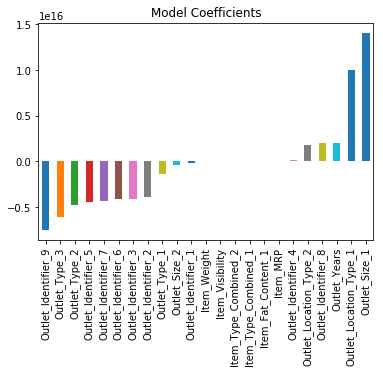

In [39]:
    #Print model report:
    print ("\nModel Report")
    #Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
    print ("Root mean squared error : %.4g" % np.sqrt(mean_squared_error(y_test, y_pred)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    coef1 = pd.Series(reg.coef_, [x for x in train.columns if x not in ['Item_Outlet_Sales','Item_Identifier', 'Outlet_Identifier']]).sort_values()
    coef1.plot(kind='bar', title='Model Coefficients')
    # The absolute value of the correlation coefficient denotes the strength of the relationship.
    #Since  absolute correlation is very high it means that the relationship is strong

# Evaluation Metrics


Evaluation metrics for classification problems, such as accuracy, are not useful for regression problems.
Instead, we need evaluation metrics designed for comparing continuous values.

In [40]:

# Mean Absolute Error (MAE) is the mean of the absolute value of the errors:
print("MAE: %.4f" % (mean_absolute_error(y_test, y_pred)))

# Mean Squared Error (MSE) is the mean of the squared errors:
print("MSE: %.4f" % (mean_squared_error(y_test, y_pred)))

#Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors, less rmse means good model:
print ("Root mean squared error : %.4f" % np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 849.3315
MSE: 1298986.3663
Root mean squared error : 1139.7308


Comparing these metrics:

MAE is the easiest to understand, because it's the average error.
MSE is more popular than MAE, because MSE "punishes" larger errors.
RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units and Easier to put in context as it's the same units as our response variable

Residuals refer to the error values of the model. Therefore lower residuals are desired.

### ‘Ridge Regression‘ and ‘Lasso Regression‘ the most fundamental regularization techniques.

Ridge Regression is a technique used when the data suffers from multicollinearity ( independent variables are highly correlated).In multicollinearity, even though the least squares estimates (OLS) are unbiased, their variances are large which deviates the observed value far from the true value. By adding a degree of bias to the regression estimates, ridge regression reduces the standard errors.


y=a+b*x+e (error term),  [error term is the value needed to correct for a prediction error between the observed and predicted value]

prediction errors can be decomposed into two sub components. First is due to the biased and second is due to the variance. Prediction error can occur due to any one of these two or both components. 

Ridge regression solves the multicollinearity problem through shrinkage parameter λ (lambda), which adds the penalities to independent parameter to shrink the parameter to have a very low variance.

This is Regularization which basically adds the penalty as model complexity increases. Regularization parameter (lambda) penalizes all the parameters except intercept so that model generalizes the data and won’t overfit.

Ridge follows L2 regularization.


URL: https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
In order to create less complex (parsimonious) model when you have a large number of features in your dataset, some of the Regularization techniques used to address over-fitting and feature selection are:

1. L1 Regularization : Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the loss function. if lambda is zero then we will get back OLS whereas very large value will make coefficients zero hence it will under-fit.

2. L2 Regularization or Ridge : Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function. if lambda is zero then you can imagine we get back OLS. However, if lambda is very large then it will add too much weight and it will lead to under-fitting. Having said that it’s important how lambda is chosen. This technique works very well to avoid over-fitting issue.

A regression model that uses L1 regularization technique is called Lasso Regression and model which uses L2 is called Ridge Regression.

The key difference between these techniques is that Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether. So, this works well for feature selection in case we have a huge number of features.

In [41]:
from sklearn.linear_model import Ridge , Lasso

In [42]:
r= Ridge(alpha=0.2, normalize=False)
## higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely restricted

In [43]:
r.fit(x_train,y_train)
yr= r.predict(x_test)

In [44]:
cv_score = cross_val_score(r, x_test, y_test, cv=20, scoring='neg_mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score))

In [45]:
cv_score

array([1196.00814656, 1070.18054945, 1169.04380886, 1183.86922046,
       1106.1196852 , 1138.82351774, 1059.70794223, 1268.48552417,
       1122.60251239, 1108.25636054, 1153.21023716, 1010.24232545,
       1097.90490391, 1254.05306905, 1280.89897897, 1286.96820744,
       1161.07807594, 1097.78912009,  991.75380028, 1048.27005118])

In [46]:
r.coef_

array([ 959.73691474,   -4.56428194,   -6.91915915,   57.51398497,
         16.77646125,  133.81548317,  123.9278797 ,   93.08732061,
       -136.6462329 ,  329.07369931,  120.59235913,   66.01215763,
        204.14717583,  -89.75959214,  205.52597474, -203.73816031,
        220.13678505, -292.3599174 ,  365.74257899,   93.08732061,
        329.07369932,   16.71389488,    4.52469458])

In [47]:
len(r.coef_)

23


Model Report
Root mean squared error : 1140
CV Score : Mean - 1140 | Std - 84.28 | Min - 991.8 | Max - 1287


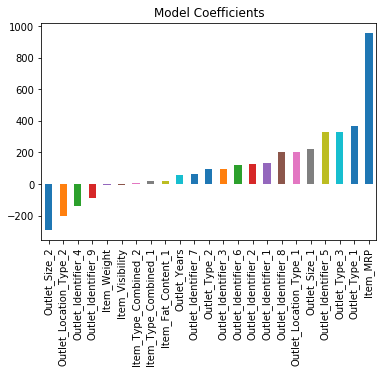

In [48]:
    #Print model report:
    print ("\nModel Report")
    #Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
    print ("Root mean squared error : %.4g" % np.sqrt(mean_squared_error(y_test, yr)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    coef1 = pd.Series(r.coef_, [x for x in train.columns if x not in ['Item_Outlet_Sales','Item_Identifier', 'Outlet_Identifier']]).sort_values()
    coef1.plot(kind='bar', title='Model Coefficients')
    # The absolute value of the correlation coefficient denotes the strength of the relationship.
    #Since  absolute correlation is very high it means that the relationship is strong

Here , magnitude of coefficients i slighty better tthan linear regression and also score is similar

In [49]:

# Mean Absolute Error (MAE) is the mean of the absolute value of the errors:
print("MAE: %.4f" % (mean_absolute_error(y_test, yr)))

# Mean Squared Error (MSE) is the mean of the squared errors:
print("MSE: %.4f" % (mean_squared_error(y_test, yr)))

#Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors, less rmse means good model:
print ("Root mean squared error : %.4f" % np.sqrt(mean_squared_error(y_test, yr)))

MAE: 849.4949
MSE: 1299125.4612
Root mean squared error : 1139.7918


In [50]:
l=Lasso(alpha=0.5, normalize=False)

In [51]:
l.fit(x_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [52]:
yl= l.predict(x_test)

In [53]:
np.sqrt(mean_squared_error(y_test,yl))

1139.8854077311082

In [54]:
cv_score = cross_val_score(r, x_test, y_test, cv=20, scoring='neg_mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score))


Model Report
Root mean squared error : 1140
CV Score : Mean - 1140 | Std - 84.28 | Min - 991.8 | Max - 1287


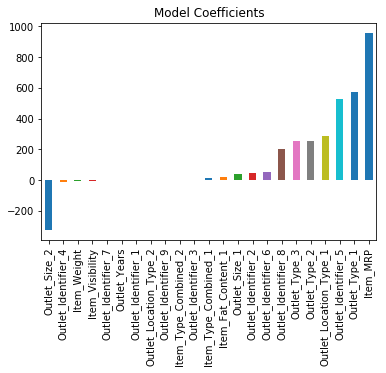

In [55]:
    #Print model report:
    print ("\nModel Report")
    #Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
    print ("Root mean squared error : %.4g" % np.sqrt(mean_squared_error(y_test, yl)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    coef1 = pd.Series(l.coef_, [x for x in train.columns if x not in ['Item_Outlet_Sales','Item_Identifier', 'Outlet_Identifier']]).sort_values()
    coef1.plot(kind='bar', title='Model Coefficients')
    # The absolute value of the correlation coefficient denotes the strength of the relationship.
    #Since  absolute correlation is very high it means that the relationship is strong

In [56]:
#applyig decision Tree regression.

# Applying the model
from sklearn.tree import DecisionTreeRegressor
decreg= DecisionTreeRegressor(max_depth=8, min_samples_leaf=50,random_state= 0)


In [57]:
decreg.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=50,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [58]:
decreg.score

<bound method RegressorMixin.score of DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=50,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')>

In [59]:
ydec= decreg.predict(x_test)

In [60]:
decreg.feature_importances_

array([5.49534914e-01, 9.88473862e-03, 3.05233043e-03, 1.56665846e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.78041484e-02,
       0.00000000e+00, 4.27471851e-02, 0.00000000e+00, 0.00000000e+00,
       1.33705873e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.13512768e-03, 1.33918063e-03, 1.67683928e-01, 2.23790372e-02,
       1.21498631e-01, 3.70618666e-05, 0.00000000e+00])

In [61]:

cv_score = cross_val_score(decreg, x_test, y_test, cv=20, scoring='neg_mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score))


Model Report
Root mean squared error : 1110
CV Score : Mean - 1118 | Std - 95.13 | Min - 981.9 | Max - 1347


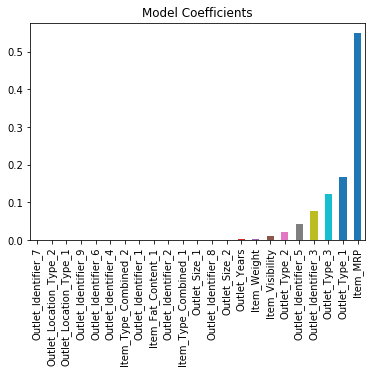

In [62]:
    #Print model report:
    print ("\nModel Report")
    #Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
    print ("Root mean squared error : %.4g" % np.sqrt(mean_squared_error(y_test, ydec)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    coef1 = pd.Series(decreg.feature_importances_, [x for x in train.columns if x not in ['Item_Outlet_Sales','Item_Identifier', 'Outlet_Identifier']]).sort_values()
    coef1.plot(kind='bar', title='Model Coefficients')
    # The absolute value of the correlation coefficient denotes the strength of the relationship.
    #Since  absolute correlation is very high it means that the relationship is strong

Now considering the top 5 features for the model


Model Report
Root mean squared error : 1107
CV Score : Mean - 1109 | Std - 85.03 | Min - 962.1 | Max - 1317


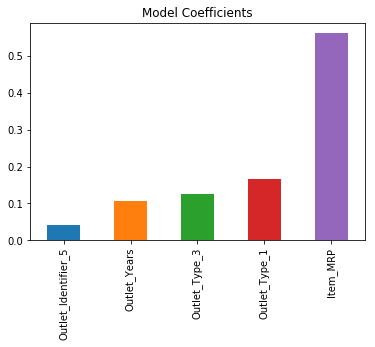

In [63]:
top5= ['Item_MRP','Outlet_Type_1','Outlet_Years','Outlet_Type_3','Outlet_Identifier_5']
y= train.loc[:,'Item_Outlet_Sales'].values
x= train.loc[:, top5].values
# we are not taking id columns as there is no use of identifiers

#splitting the data of training and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/3, random_state = 0)


decreg= DecisionTreeRegressor(max_depth=8, min_samples_leaf=50,random_state= 0)
decreg.fit(x_train, y_train)


ydec= decreg.predict(x_test)
cv_score = cross_val_score(decreg, x_test, y_test, cv=20, scoring='neg_mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score))
print ("\nModel Report")
#Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
print ("Root mean squared error : %.4g" % np.sqrt(mean_squared_error(y_test, ydec)))
print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
coef1 = pd.Series(decreg.feature_importances_, top5).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')


## Random Forest

Random Forest is a versatile machine learning method capable of performing both regression and classification tasks. It also undertakes dimensional reduction methods, treats missing values, outlier values and other essential steps of data exploration, and does a fairly good job. It is a type of ensemble learning method, where a group of weak models combine to form a powerful model.


Model Report
Root mean squared error : 1095
CV Score : Mean - 1109 | Std - 88.32 | Min - 949.3 | Max - 1294


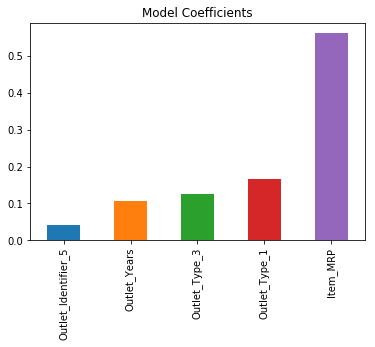

In [64]:
from sklearn.ensemble import RandomForestRegressor

regrf= RandomForestRegressor(n_estimators=200,max_depth=8,min_samples_leaf=50,n_jobs=4)

regrf.fit(x_train,y_train)

regrf.feature_importances_

yrf= regrf.predict(x_test)
cv_score = cross_val_score(regrf, x_test, y_test, cv=20, scoring='neg_mean_squared_error')
cv_score = np.sqrt(np.abs(cv_score))
print ("\nModel Report")
#Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
print ("Root mean squared error : %.4g" % np.sqrt(mean_squared_error(y_test, yrf)))
print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
coef1 = pd.Series(decreg.feature_importances_, top5).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')